# **ExpLogic**

### **Setting up**

#### **Dependencies**

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import yaml
import os
import cv2
import time
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.transforms import Resize, ToTensor, Compose, Lambda
import mnist_dataset
from hydra import initialize, compose
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset
from difflogic import LogicLayer, GroupSum, PackBitsTensor
import subset_loaders as subset
import data_getter as dat


In [2]:
import importlib
dat = importlib.reload(dat)


#### **Dataset**

Tunable Variables

In [3]:
# Configurable options
crop          = None             # (x,x) else None: Removes border of Mnist, False: Keeps black border around digits
dataset_name  = "fashion_mnist"  # "mnist"/"fashion_mnist" 
bpp           = 1                # Bits-Per-Pixels (fixed at 1 for ExpLogic for the binary case) 

Set Seed for Reproducibiity

In [4]:
torch.manual_seed(42)      # PyTorch seed fixing
torch.cuda.manual_seed(42) # PyTorch CUDA seed fixing (if using GPU)
np.random.seed(42)         # NumPy seed fixing
random.seed(42)            # Python's built-in random seed fixing

Dataset Transform

In [8]:
batch_size=64
train_loader, test_loader, input_dim, out_dim = dat.get_dataset(dataset_name, batch_size=batch_size, data_dir='./data', bpp=bpp, crop=crop)

In [9]:
# makes the Dataset evenly partitioned
# code below is used so that all classes have the same number of samples
train_targets = train_loader.dataset.targets
test_targets = test_loader.dataset.targets

train_digits_total = []
test_digits_total = []

for i in range(10):
    curr_tot_train = torch.sum(train_targets == i).item()
    curr_tot_test = torch.sum(test_targets == i).item()    
    train_digits_total.append(curr_tot_train)
    test_digits_total.append(curr_tot_test)

train_digits_total, test_digits_total

# find the minimum number of samples across all classes
min_samples_train = min(train_digits_total)
min_samples_test = min(test_digits_total)

# function to trim dataset to match the minimum samples for each class and shuffle indices
def trim_dataset(dataset, targets, min_samples):
    indices = []
    for i in range(10):
        class_indices = (targets == i).nonzero(as_tuple=True)[0]  # get indices of class i
        class_indices = class_indices[:min_samples]  # trim to min_samples
        indices.extend(class_indices)

    # shuffle indices after collecting them
    indices = torch.tensor(indices)
    indices = indices[torch.randperm(indices.size(0))]  

    return Subset(dataset, indices)

# trim both train and test datasets to ensure all classes have the same number of samples
trimmed_train_dataset = trim_dataset(train_loader.dataset, train_targets, min_samples_train)
trimmed_test_dataset = trim_dataset(test_loader.dataset, test_targets, min_samples_test)

# create DataLoaders for the trimmed datasets
trimmed_train_loader = DataLoader(trimmed_train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
trimmed_test_loader = DataLoader(trimmed_test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=True)

# verify the lengths of the trimmed datasets
len(trimmed_train_loader.dataset), len(trimmed_test_loader.dataset)

train_dataset = trimmed_train_dataset
test_dataset = trimmed_test_dataset
train_loader = trimmed_train_loader
test_loader = trimmed_test_loader

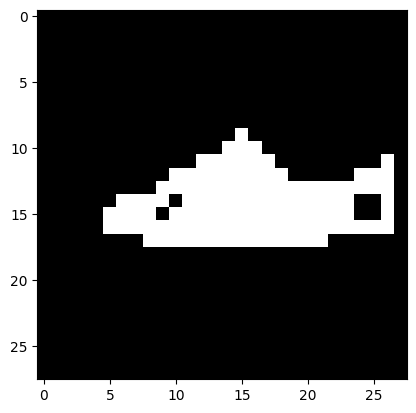

In [204]:
# visualizing a single image
dataset_size = len(train_dataset)
random_index = random.randint(0, dataset_size - 1)
image        = np.array(train_loader.dataset[random_index][0])
shape        = (20,20) if crop else (28,28)
image        = np.array([np.sum([image[(j*bpp) + p]*(2**(bpp-p+1)) for p in range(bpp)]) for j in range(shape[0]*shape[0])]).reshape(shape)

plt.figure()
plt.imshow(image, cmap='gray')

#### Model Hyperparameters

Converts csv into yaml config file

In [14]:
# define first input and the name of the file to be saved
if dataset_name == "mnist":
    first_in_dim = 400*bpp
    filename = "config/mnist_config_20x20.yaml"
    df = pd.read_csv("config/mnist_hyperparameters.csv")
elif dataset_name == "fashion_mnist":
    first_in_dim = 784*bpp
    filename = "config/fashion_mnist_config_28x28.yaml"
    df = pd.read_csv("config/fashion_mnist_hyperparameters.csv")

In [15]:

# convert the DataFrame to a list of dictionaries
models = df.to_dict(orient="records")

# create the YAML structure
yaml_structure = {"models": {}}

# rounds the number to the nearest multiple of the output size
def round_to_nearest_multiple(value, multiple):
    return multiple * round(value / multiple)

# populate the YAML structure with models
for i, model in enumerate(models, start=1):
    # zero-padding model names to 3 digits 
    model_name = f"model_{str(i).zfill(3)}"
    layers_config = {}
    
    for layer in range(1, model["H"] + 1):
        # zero-padding the layer names to 3 digits
        layer_name = f"LogicLayer{str(layer).zfill(3)}"
        
        # adjusts in_dim to the nearest multiple of 10
        in_dim = first_in_dim if layer == 1 else round_to_nearest_multiple(model["W"], 10)
        
        # adjusts out_dim to the nearest multiple of 10
        out_dim = round_to_nearest_multiple(model["W"], 10)
        
        layers_config[layer_name] = {
            "in_dim": in_dim,
            "out_dim": out_dim,
            "device": "cuda",
            "implementation": "cuda",
            "connections": "random",
            "grad_factor": 2, # we can try different grad_factor values as well
        }
    
    yaml_structure["models"][model_name] = {
        "input_dim": first_in_dim, 
        "output_size": 10, # for MNIST classification
        "tau": model["tau"],
        "learning_rate": model["lr"],
        "layers_config": layers_config,
    }

# saves to a YAML file
with open(f'{filename}', "w") as file:
    yaml.dump(yaml_structure, file, default_flow_style=False)

print(f"YAML file '{filename}' generated successfully.")

YAML file 'config/fashion_mnist_config_28x28.yaml' generated successfully.


### **Model Definition**

#### **Model Function Declarations**

Custom GroupSum

In [16]:
class CustomGroupSum(GroupSum):
    """
    The CustomGroupSum module that extends GroupSum to include printing of class sums.
    """
    def forward(self, x):
        # Use the original functionality from GroupSum
        output = super().forward(x)

        # Calculate the class sums for printing
        if isinstance(x, PackBitsTensor):
            class_sums = x.group_sum(self.k)
        else:
            class_sums = x.reshape(*x.shape[:-1], self.k, x.shape[-1] // self.k).sum(-1)

        # Print the class sums before returning the output
        print("Class Sums:", class_sums)

        # Return the processed output, as in the original GroupSum
        return output

DiffLogic Class

In [73]:
class DiffLogic(nn.Module):
    def __init__(self, layers_config, output_size, tau=30):
        """
        Initializes the DiffLogic model with the specified layer configurations, output size, and temperature parameter.

        Args:
            layers_config (dict): Configuration for each logic layer, including dimensions, device, implementation, connections, and grad factor.
            output_size (int): The number of output groups (classes in a classification problem).
            tau (int): Temperature parameter for the GroupSum operation.
        """
        super(DiffLogic, self).__init__()
        
        # stores the logic layers
        layers = []
        for layer_name, config in layers_config.items():
            layer = LogicLayer(
                in_dim=config['in_dim'],
                out_dim=config['out_dim'],
                device=config['device'],
                implementation=config['implementation'],
                connections=config['connections'],
                grad_factor=config['grad_factor']       
            )
            layers.append(layer)
            print(layer)
        
        self.logic_layers = nn.Sequential(*layers)
        self.group = GroupSum(k=output_size, tau=tau)
        #self.group = CustomGroupSum(k=output_size, tau=tau) 
        self.log_text = ""  # initializes logging string

    def forward(self, x):
        """
        Forward pass of the DiffLogic model.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Output tensor after processing through the logic layers and grouping operation.
        """
        # moves tensor to GPU
        if torch.cuda.is_available():
            x = x.to('cuda')          
        x = torch.flatten(x)
        logits = self.logic_layers(x)
        group = self.group(logits)
        return group
    
    def save(self, file_path, model_name='model'):
        """
        Saves the model's state dictionary to the specified file path.

        Args:
            file_path (str): Path where the model will be saved.
            model_name (str): Name of the saved model

        Returns:
            None
        """
        torch.save({
            'model_state_dict': self.state_dict(),
            'connections': [layer.indices for layer in self.logic_layers if isinstance(layer, LogicLayer)]
        }, os.path.join(file_path, f"{model_name}.pth"))
        self.log_text += f"Model saved to: {file_path}\n"

    def load(self, file_path):
        """
        Loads the model's state dictionary from the specified file path.

        Args:
            file_path (str): Path from which the model will be loaded.

        Returns:
            None
        """
        checkpoint = torch.load(file_path)
        self.load_state_dict(checkpoint['model_state_dict'])

        # assigns connections to each LogicLayer
        for idx, layer in enumerate(self.logic_layers):
            if isinstance(layer, LogicLayer):
                layer.indices = checkpoint['connections'][idx]

        self.eval()
        self.log_text += f"Model loaded from: {file_path}\n"
        
    def get_accuracy(self, data_loader):
        """
        Calculates the accuracy of the model against a data loader

        Args:
            data_loader: a DataLoader object, e.g. train_loader or test_loader

        Returns:
            float: The accuracy
        """
        correct = 0
        total = 0

        # ensures that model is in evaluation mode
        self.eval()

        with torch.no_grad():  # Disable gradient calculation for inference
            for batch_inputs, batch_outputs in tqdm(data_loader, desc="Running Inference"):
                batch_inputs, batch_outputs = batch_inputs.to('cuda'), batch_outputs.to('cuda')

                # forward pass to get predictions
                outputs = self(batch_inputs.float())

                # gets the predicted class (index of the maximum logit)
                _, predicted = torch.max(outputs.data, 1)

                # counting correct predictions
                total += batch_outputs.size(0)  # total number of samples in the batch
                correct += (predicted == batch_outputs).sum().item()  # counting correct predictions

        accuracy = correct / total
        return accuracy

    def get_log(self):
        """
        Retrieves the log text and clears the log after retrieval.

        Returns:
            str: The log text.
        """
        log_copy = self.log_text
        self.log_text = ""  # Clear the log after returning
        return log_copy

In [18]:
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        """
        Initializes the EarlyStopper to stop training if the performance doesn't improve after a certain number of epochs.

        Args:
            patience (int): Number of epochs to wait for an improvement.
            min_delta (float): Minimum change to consider an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def should_stop(self, current_loss):
        """
        Check if training should stop based on the current loss.

        Args:
            current_loss (float): The current loss.

        Returns:
            bool: True if training should stop, False otherwise.
        """
        if self.best_loss is None:
            self.best_loss = current_loss
            return False
        elif current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            print("EarlyStopper Triggered: ", self.counter)
            if self.counter >= self.patience:
                return True
            return False

#### **Model Training**

In [42]:
# initialize Hydra with the config path and job name
with initialize(version_base=None, config_path="config", job_name="ExpLogic"):
    cfg = compose(config_name=f"{dataset_name}_config_{shape[0]}x{shape[0]}")

# training loop for all models
all_models_dict = {}
num_epochs = 25
file_path = f'{dataset_name}_trained_models' # where to save your trained models

# loops through all model configs and trains each of them
for model_name, model_cfg in cfg.models.items():
    print(f'training model {model_name}')

    # tracking dictionary
    all_models_dict[model_name] = {
        'losses': [],
    }

    try:
        # initializes DiffLogic model and moves to CUDA if available
        model = DiffLogic(layers_config=model_cfg['layers_config'], 
                          output_size=model_cfg['output_size'], 
                          tau=model_cfg['tau']).to('cuda' if torch.cuda.is_available() else 'cpu')
        
        # optimizer and loss criterion
        optimizer = torch.optim.Adam(model.parameters(), lr=model_cfg['learning_rate'])
        criterion = nn.CrossEntropyLoss()
        
        # early stopping
        early_stopper = EarlyStopper(patience=5)

        for epoch in range(num_epochs):
            loop = tqdm(train_loader, leave=True, desc=f'Epoch {epoch+1}/{num_epochs}')
            epoch_loss = 0  # to track loss for an epoch
            
            for batch_inputs, batch_outputs in loop:
                # move data to the appropriate device
                device = 'cuda' if torch.cuda.is_available() else 'cpu'
                batch_inputs, batch_outputs = batch_inputs.to(device).double(), batch_outputs.to(device).long()

                # forward pass through the model
                predictions = model(batch_inputs)
                loss = criterion(predictions, batch_outputs)

                # zero gradients, backpropagates, and updates model parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # accumulating the loss for the epoch
                epoch_loss += loss.item()

            # caclulating the average loss for the epoch
            epoch_loss /= len(train_loader)
            all_models_dict[model_name]['losses'].append(epoch_loss)
            print(f'Epoch {epoch+1} Loss: {epoch_loss}')

            # checks for early stopping
            if early_stopper.should_stop(epoch_loss):
                print(f"Early stopping triggered for {model_name} at epoch {epoch+1}.")
                break

        # saving trained model's state
        model.save(file_path, model_name)

    except Exception as e:
        print(f"ERROR TRAINING {model_name.upper()}: {str(e)}")

print("All models processed.")

training model model_001
LogicLayer(784, 5000, train)
LogicLayer(5000, 5000, train)


Epoch 1/25: 100%|██████████| 937/937 [01:59<00:00,  7.86it/s]


Epoch 1 Loss: 1.6926728826300046


Epoch 2/25: 100%|██████████| 937/937 [02:00<00:00,  7.76it/s]


Epoch 2 Loss: 0.98583178520808


Epoch 3/25: 100%|██████████| 937/937 [02:00<00:00,  7.78it/s]


Epoch 3 Loss: 0.8032486476842099


Epoch 4/25: 100%|██████████| 937/937 [02:00<00:00,  7.81it/s]


Epoch 4 Loss: 0.7288143128308687


Epoch 5/25: 100%|██████████| 937/937 [02:00<00:00,  7.76it/s]


Epoch 5 Loss: 0.6847510552931589


Epoch 6/25: 100%|██████████| 937/937 [02:00<00:00,  7.75it/s]


Epoch 6 Loss: 0.6549393972699935


Epoch 7/25: 100%|██████████| 937/937 [02:00<00:00,  7.75it/s]


Epoch 7 Loss: 0.6325606659758012


Epoch 8/25: 100%|██████████| 937/937 [02:00<00:00,  7.79it/s]


Epoch 8 Loss: 0.6151780364143242


Epoch 9/25: 100%|██████████| 937/937 [01:59<00:00,  7.84it/s]


Epoch 9 Loss: 0.6010541678532972


Epoch 10/25: 100%|██████████| 937/937 [02:00<00:00,  7.77it/s]


Epoch 10 Loss: 0.5890794506338193


Epoch 11/25: 100%|██████████| 937/937 [01:59<00:00,  7.85it/s]


Epoch 11 Loss: 0.5791281322255114


Epoch 12/25: 100%|██████████| 937/937 [02:00<00:00,  7.79it/s]


Epoch 12 Loss: 0.5705444525542824


Epoch 13/25: 100%|██████████| 937/937 [02:00<00:00,  7.77it/s]


Epoch 13 Loss: 0.5632077111178746


Epoch 14/25: 100%|██████████| 937/937 [01:59<00:00,  7.84it/s]


Epoch 14 Loss: 0.5564425213301176


Epoch 15/25: 100%|██████████| 937/937 [02:00<00:00,  7.77it/s]


Epoch 15 Loss: 0.5503506645161996


Epoch 16/25: 100%|██████████| 937/937 [01:59<00:00,  7.85it/s]


Epoch 16 Loss: 0.5450929105755163


Epoch 17/25: 100%|██████████| 937/937 [02:00<00:00,  7.76it/s]


Epoch 17 Loss: 0.5400230619373423


Epoch 18/25: 100%|██████████| 937/937 [02:00<00:00,  7.76it/s]


Epoch 18 Loss: 0.5355854582488747


Epoch 19/25: 100%|██████████| 937/937 [02:00<00:00,  7.76it/s]


Epoch 19 Loss: 0.5314182750131282


Epoch 20/25: 100%|██████████| 937/937 [01:59<00:00,  7.84it/s]


Epoch 20 Loss: 0.5275707794355929


Epoch 21/25: 100%|██████████| 937/937 [01:59<00:00,  7.84it/s]


Epoch 21 Loss: 0.5239306066015796


Epoch 22/25: 100%|██████████| 937/937 [02:00<00:00,  7.76it/s]


Epoch 22 Loss: 0.5206937881290001


Epoch 23/25: 100%|██████████| 937/937 [02:00<00:00,  7.77it/s]


Epoch 23 Loss: 0.517589286599412


Epoch 24/25: 100%|██████████| 937/937 [02:01<00:00,  7.74it/s]


Epoch 24 Loss: 0.5146114805801795


Epoch 25/25: 100%|██████████| 937/937 [01:59<00:00,  7.82it/s]


Epoch 25 Loss: 0.5119477586595819
All models processed.


#### **Model Testing**

In [43]:
if "model_002" in cfg['models'].keys(): 
    print("test")

In [44]:
# testing loop to test inferences
trained_models_dir = f'{dataset_name}_trained_models/'

# retrieves a list of all model files in the directory
model_files = sorted([f for f in os.listdir(trained_models_dir) if f.endswith('.pth')])

with initialize(version_base=None, config_path="config", job_name="ExpLogic_Test"):
    cfg = compose(config_name=f"{dataset_name}_config_{shape[0]}x{shape[0]}")

# dictionary to store the trained models
trained_models = {}
trained_models_accuracies = {}

# loops through all model files and calculates their accuracies
for i, model_file in enumerate(model_files):
    if model_file.endswith('_weights.pth'):
        model_name = model_file.removesuffix('_weights.pth')
    else:
        model_name = model_file.removesuffix('.pth')
    if model_name in cfg['models'].keys(): 
        model_cfg = cfg['models'][model_name]

        # instantiates the model and load its weights
        model = DiffLogic(layers_config=model_cfg['layers_config'], 
                              output_size=model_cfg['output_size'], 
                              tau=model_cfg['tau']).to('cuda' if torch.cuda.is_available() else 'cpu')

        model_path = os.path.join(trained_models_dir, model_file)
        print(f"Evaluating {model_file}...")

        # loads the respective model
        model.load(model_path)

        # calculates accuracy
        accuracy = model.get_accuracy(test_loader)

        print(f"Accuracy of {model_file}: {accuracy * 100:.2f}%\n")

        trained_models[i] = model
        trained_models_accuracies[i] = accuracy

LogicLayer(784, 5000, train)
LogicLayer(5000, 5000, train)
Evaluating model_001.pth...


Running Inference: 100%|██████████| 156/156 [00:20<00:00,  7.70it/s]

Accuracy of model_001.pth: 76.98%



### **Switching Probability**

Converting DiffLogic to LogicGraph

In [45]:
import LogicGraph as lg 
import importlib as lib
lg = lib.reload(lg)

print("Creating LogicGraph")
gall = lg.LogicGraph(model)

gall.compute_sf(test_loader)
gall.compute_sp(np.ones((shape[0],shape[1]))-0.5)

# Example of accessing the gate type per edge
#gall.edges()[('L1_N576', 'L2_N1210')]["ab"]


Creating LogicGraph


Processing MNIST images: 100%|██████████| 156/156 [00:34<00:00,  4.50it/s]


#### **Difference of SP for Individual Classes**

Find the TP, TN, FP, FN instances, and use this to create sub-datasets for specific cases 
(NOTE: This section will take some time to run)

In [46]:
# set to True if you have already created the files
saved = False 

In [47]:
import pickle

def pkl_save(data, file): 
    with open(file, "wb") as file: 
        pickle.dump(data, file)    

# Load the object from a file
def pkl_load(file): 
    with open("data.pkl", "rb") as file:  # 'rb' means read in binary mode
        data = pickle.load(file)
    return data

def predict_and_categorize(model, data_loader):

    all_images      = []
    all_labels      = []
    all_predictions = []

    # Ensure model is in evaluation mode
    model.eval()

    with torch.no_grad():  # Disable gradient calculation for inference
        for batch_inputs, batch_outputs in tqdm(data_loader, desc="Predicting"):
            batch_inputs, batch_outputs = batch_inputs.to('cuda'), batch_outputs.to('cuda')

            # Forward pass to get predictions
            outputs = model(batch_inputs.float())

            # Get the predicted class (index of the maximum logit)
            _, predicted = torch.max(outputs.data, 1)

            all_images.append(batch_inputs.cpu())
            all_labels.append(batch_outputs.cpu())
            all_predictions.append(predicted.cpu())

    all_images = torch.cat(all_images)
    all_labels = torch.cat(all_labels)
    all_predictions = torch.cat(all_predictions)

    return all_images, all_labels, all_predictions

# Usage:
all_images_train, all_labels_train, all_predictions_train = predict_and_categorize(model, train_loader)
all_images_test,  all_labels_test,  all_predictions_test  = predict_and_categorize(model,  test_loader) 

# Fix random seeds for reproducibility
torch.manual_seed(42)            
torch.cuda.manual_seed(42)        
np.random.seed(42)

# If using CUDA:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Init parameters
batch_size = 256   # this can be tuned as well 

# Create class-specific data loaders for training and testing sets
train_class_loaders = subset.create_class_dataloaders(train_dataset, batch_size)
test_class_loaders  = subset.create_class_dataloaders(test_dataset,  batch_size)

# Create TN/TP/FN/FP datasets
general_datasets        = subset.create_tn_tp_fn_fp_datasets(all_images_train, all_labels_train, all_predictions_train)
class_specific_datasets = subset.create_class_specific_datasets(all_images_train, all_labels_train, all_predictions_train)

# For the general TN, TP, FN, FP datasets:
t_dataset = DataLoader(general_datasets['T'],batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
f_dataset = DataLoader(general_datasets['F'],batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)

# For class-specific datasets (e.g., for class 5):
for i in range(10): 
    class_specific_datasets['TP_class'][i] = DataLoader(class_specific_datasets['TP_class'][i],batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
    class_specific_datasets['FP_class'][i] = DataLoader(class_specific_datasets['FP_class'][i],batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
    class_specific_datasets['TN_class'][i] = DataLoader(class_specific_datasets['TN_class'][i],batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
    class_specific_datasets['FN_class'][i] = DataLoader(class_specific_datasets['FN_class'][i],batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)

Predicting: 100%|██████████| 156/156 [00:19<00:00,  8.16it/s]


Saving the Class Datasets
Saving the General Datasets
Saving the General Datasets
Saving the Class-Specific Datasets


Class Specific Differences

In [48]:
outputs = [f"L3_N0", f"L3_N1", f"L3_N2", f"L3_N3", f"L3_N4", f"L3_N5", f"L3_N6", f"L3_N7", f"L3_N8", f"L3_N9"]

p_maps = []
sp_graphs = [] 
sp_diffs = [] 
for j, output_node in enumerate(outputs): 
    p_maps.append(cv2.imread(f"mnist_averages/average_digit_{j}.png")[4:24,4:24,1]/255)
    sp_graph  = copy.deepcopy(gall)
    sp_graph.compute_sp(p_maps[j])
    sp_graphs.append(sp_graph)
    sp_diffs.append(sp_graph.sub_sp(gall))
    
# Compute SF for each graph
graphs = {}
for g in range(10): 
    print(f"Class {g}")
    graphs[g] = lg.LogicGraph(model)
    graphs[g].compute_sf(train_class_loaders[g])


Class 0


Processing MNIST images: 100%|██████████| 23/23 [00:13<00:00,  1.65it/s]


Class 1


Processing MNIST images: 100%|██████████| 23/23 [00:13<00:00,  1.65it/s]


Class 2


Processing MNIST images: 100%|██████████| 23/23 [00:13<00:00,  1.67it/s]


Class 3


Processing MNIST images: 100%|██████████| 23/23 [00:13<00:00,  1.67it/s]


Class 4


Processing MNIST images: 100%|██████████| 23/23 [00:13<00:00,  1.67it/s]


Class 5


Processing MNIST images: 100%|██████████| 23/23 [00:13<00:00,  1.67it/s]


Class 6


Processing MNIST images: 100%|██████████| 23/23 [00:13<00:00,  1.67it/s]


Class 7


Processing MNIST images: 100%|██████████| 23/23 [00:13<00:00,  1.68it/s]


Class 8


Processing MNIST images: 100%|██████████| 23/23 [00:15<00:00,  1.53it/s]


Class 9


Processing MNIST images: 100%|██████████| 23/23 [00:12<00:00,  1.83it/s]


In [49]:
# Compute SF for each graph
fps = {}
tps = {}
fns = {}
tns = {}
for g in range(10): 
    print(g)
    fps[g] = lg.LogicGraph(model)
    if [i for i in class_specific_datasets['FP_class'][g]] != []:
        fps[g].compute_sf(class_specific_datasets['FP_class'][g])
    #tps[g] = LogicGraph(model)
    #if [i for i in class_specific_datasets['TP_class'][g]] != []:
    #    tps[g].compute_sf(class_specific_datasets['TP_class'][g])
    fns[g] = lg.LogicGraph(model)
    if [i for i in class_specific_datasets['FN_class'][g]] != []:
        fns[g].compute_sf(class_specific_datasets['FN_class'][g])
    tns[g] = lg.LogicGraph(model)
    if [i for i in class_specific_datasets['TN_class'][g]] != []:
        tns[g].compute_sf(class_specific_datasets['TN_class'][g])

0


Processing MNIST images: 100%|██████████| 200/200 [00:19<00:00, 10.32it/s]


1


Processing MNIST images: 100%|██████████| 210/210 [00:21<00:00,  9.73it/s]


2


Processing MNIST images: 100%|██████████| 206/206 [00:20<00:00,  9.89it/s]


3


Processing MNIST images: 100%|██████████| 203/203 [00:20<00:00,  9.91it/s]


4


Processing MNIST images: 100%|██████████| 198/198 [00:20<00:00,  9.80it/s]


5


Processing MNIST images: 100%|██████████| 208/208 [00:21<00:00,  9.85it/s]


6


Processing MNIST images: 100%|██████████| 205/205 [00:20<00:00,  9.84it/s]


7


Processing MNIST images: 100%|██████████| 205/205 [00:20<00:00,  9.82it/s]


8


Processing MNIST images: 100%|██████████| 210/210 [00:21<00:00,  9.78it/s]


9


Processing MNIST images: 100%|██████████| 208/208 [00:20<00:00, 10.37it/s]


In [50]:
# Compute SF Diff for each combination
print("Computing diffs")
diffs = {}
for i in range(10): 
    diff = {} 
    for j in range(10): 
        diff[j] = graphs[i] - graphs[j]
    diffs[i] = diff

print("Computing centered")
centered = {}
for i in range(10): 
    centered[i] = graphs[i] - gall
    
print("Computing specific")
specific = {}
for i in range(10): 
    specific[i] = graphs[i] - tns[i]    

Computing diffs
Computing centered
Computing specific


Initialize helper functions for visualizing the FAN-IN

In [51]:
a_not_list = ["not_implied_by", "not_or","not_xor","not_a","implies","not_and"]
b_not_list = ["not_implies", "not_or","not_xor","not_b","implied_by","not_and"]

def find_fan_in(G, output_node, threshold,metric="sf"):
    """
    Find all input nodes connected to the given output node.
    """
    fan_in = set()
    nodes_to_check = [(output_node,1)]
    input_set = []
    while nodes_to_check:
        
        # Get node and node properties 
        parent_node, dpo = nodes_to_check.pop(0)
        new_fan_in  = []
        child_gates = []
        parent_type = G.nodes[parent_node]["gate"]
        
        # Account for all predesesors
        for child_node in list(G.predecessors(parent_node)): 
            
            desired_parent_output = dpo*1
            
            # Get type of child node 
            child_type = G.nodes[child_node]["gate"]
            
            # Account for output case 
            if parent_type == "output": 

                # Check whether the current node is contributing to the class output
                desired_child_output = desired_parent_output
                if G.nodes[child_node][metric] > threshold: 
                    child_gates.append((child_node, desired_child_output))
                    new_fan_in.append((child_node,  desired_child_output))

            # Account for hidden-layer case 
            elif child_node != "input": 

                # Get the current wire type
                props     = G.get_edge_data(child_node, parent_node)
                wire_type = props["ab"] if "ab" in props.keys() else None

                # Check whether the current wire increases the class score by being zero
                if (wire_type == "a" and parent_type in a_not_list) or (wire_type == "b" and parent_type in b_not_list): 
                    
                    # Adjust the "desired child output"
                    desired_child_output = -desired_parent_output
                    
                    # Check whether the current node is contributing to the class output
                    if G.nodes[child_node][metric] <= threshold: # Less than because we contribute by being a zero 
                        child_gates.append((child_node,desired_child_output))
                        new_fan_in.append((child_node,desired_child_output))
                    
                # Case where the current wire increases the class score by being a one
                else: 
                    
                    # Adjust the "desired child output"
                    desired_child_output = desired_parent_output
                    
                    # Check whether the current node is contributing to the class output
                    if G.nodes[child_node][metric] > threshold: 
                        child_gates.append((child_node,desired_child_output))
                        new_fan_in.append((child_node,desired_child_output))

            # Account for input case
            else: 
                
                # Get the current wire type
                props = G.get_edge_data(child_node, parent_node)
                wire_type = props["ab"] if "ab" in props.keys() else None

                # Check whether the current wire increases the class score by being zero
                if (wire_type == "a" and parent_type in a_not_list) or (wire_type == "b" and parent_type in b_not_list): 
                    
                    # Adjust the "desired child output"
                    child_sign = -1*parent_sign
                    new_fan_in.append(  (child_node, child_sign))
                    input_set.append( (child_node, child_sign))
                    
                # Case where the current wire increases the class score by being a one
                else: 
                    
                    # Adjust the "desired child output"
                    child_sign = parent_sign
                    new_fan_in.append(  (child_node, child_sign))
                    input_set.append( (child_node, child_sign))
                        
        fan_in.update(new_fan_in)
        nodes_to_check.extend(child_gates)

    return fan_in, input_set

def node_to_pixel(node_id):
    """
    Convert a node ID (e.g., 'L0_Gate 1') to pixel coordinates.
    Assumes the input layer corresponds to a 28x28 image (MNIST format).
    """
    if (node_id != "HIGH") and (node_id != "LOW"): 
        layer, gate = node_id.split('_')
        
        gate_num = int(gate.split("N")[1]) - 1  # Convert 'Gate X' to zero-based index

        if layer == 'L0':  # Input layer
            y = gate_num // shape[1]
            x = gate_num % shape[0]
            return (x, y)
        
    return None  # For non-input layers, return None

def visualize_fan_in(G, output_node,threshold,signed=True, show=False,metric="sf"):
    """
    Visualize the fan-in of the given output node as highlighted pixels in an image.
    """
    fan_in,pixels = find_fan_in(G, output_node,threshold,metric)
    # Create a blank 28x28 image
    img = np.zeros(shape)
    
    # Highlight pixels corresponding to input nodes in the fan-in
    for node,sign in fan_in:
        pixel = node_to_pixel(node)
        if pixel:
            x, y = pixel
            if signed: 
                img[y, x] += sign  # Set pixel to white (1)
            else: 
                img[y, x] += 1  # Set pixel to white (1)

    if show: 
        # Plot the image
        plt.imshow(img)
        plt.title(f"Fan-in visualization for {output_node}")
        plt.colorbar()
        plt.axis('off')
        plt.show()
    
    return img, fan_in,pixels

Visualize the saliency maps for the FAN-IN (Class specific SF, and Global SF)

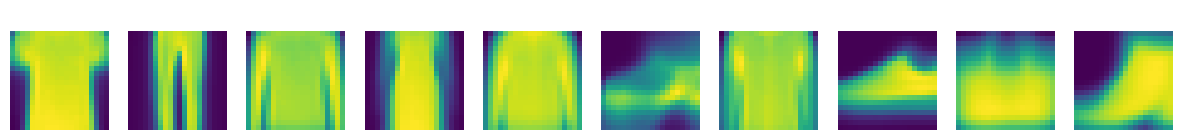

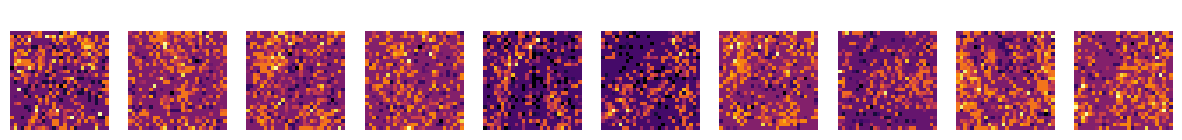

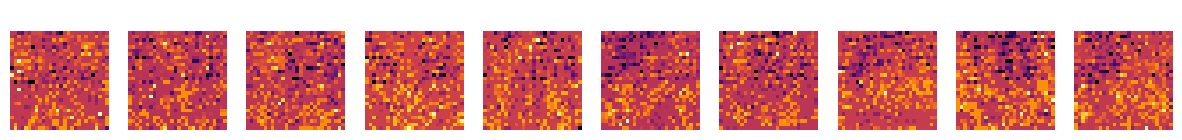

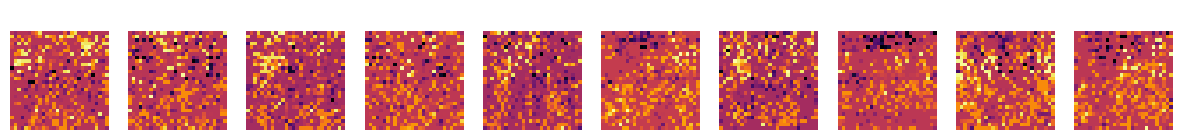

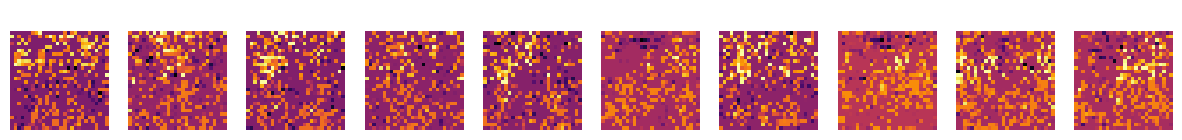

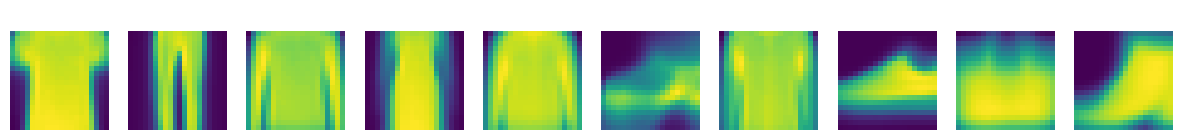

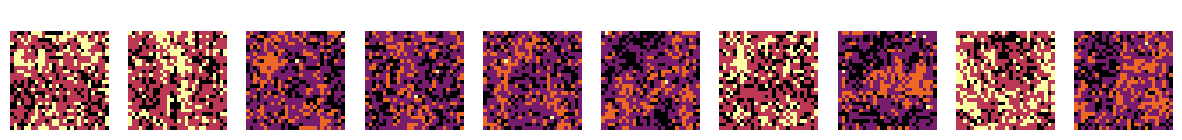

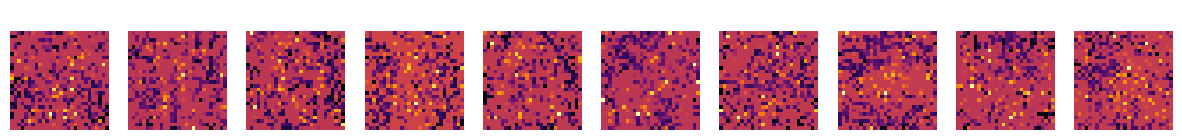

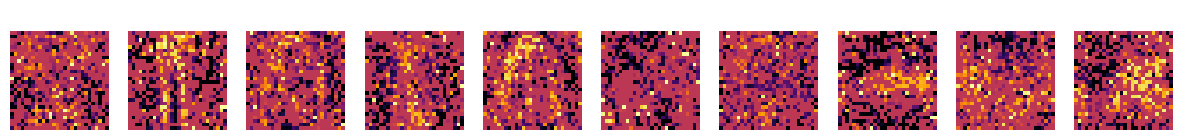

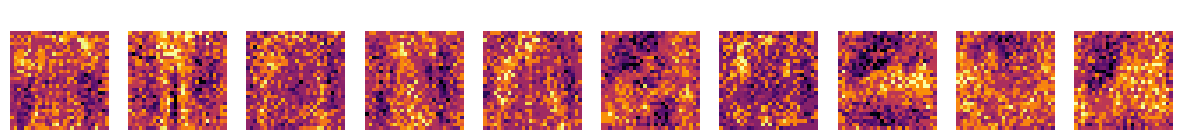

In [196]:
thresholds = [float(i)/100-1.0 for i in range(200)]
#thresholds = [0.0]
outputs = [f"L3_N0", f"L3_N1", f"L3_N2", f"L3_N3", f"L3_N4", f"L3_N5", f"L3_N6", f"L3_N7", f"L3_N8", f"L3_N9"]
test = False


def plot_row(g,thresholds,signed,metric): 
    # Plot pixel attribution  
    fig, ax = plt.subplots(1, len(outputs), figsize=(15, 10))
    for i, output_node in enumerate(outputs): 
        G = g[i].g
        im = []
        for threshold in thresholds: 
            img, fan_in,pixels = visualize_fan_in(G, output_node, threshold,signed, False,metric)
            im.append(img)
        img  = np.average(im,axis=0)
        ax[i].imshow(img,cmap="inferno")
        ax[i].title.set_text(" ")#(f"{i}")
        ax[i].set_axis_off()
    plt.show()
    
print("#################################################### MNIST ####################################################")if test else None 
import copy 
fig, ax = plt.subplots(1, len(outputs), figsize=(15, 10))
p_maps = []
sp_graphs = [] 
sp_diffs = [] 
for j, output_node in enumerate(outputs): 
    p_maps.append(cv2.imread(f"{dataset_name}_averages/average_{j}.png")[4:24,4:24,1]/255)
    sp_graph  = copy.deepcopy(gall)
    sp_graph.compute_sp(p_maps[j])
    sp_graphs.append(sp_graph)
    sp_diffs.append(sp_graph.sub_sp(gall))
    ax[j].imshow(p_maps[j])
    ax[j].title.set_text(" ")#(f"{j}")
    ax[j].set_axis_off()
plt.show()
#burn = cv2.imread(f"mnist_averages/average_all_digits.png")
#ax[len(outputs)].imshow(burn[4:24,4:24,1])


t1 = [float(i)/100 for i in range(100)]
t2 = [float(i)/100-0.5 for i in range(100)]


print("#################################################### Switch Probability ####################################################")if test else None 

print("--- Uniform 0.5") if test else None 
gall.compute_sp(np.ones(shape)-0.5)
plot_row([gall for i in range(len(graphs))],t1,True,"sp")

print("--- Average of All MNIST Digits") if test else None 
p_maps.append(cv2.imread(f"mnist_averages/average_all.png")[4:24,4:24,1]/255)
gall.compute_sp(p_maps[-1])
plot_row([gall for i in range(len(graphs))],t1,True,"sp")

print("--- Average of Class-Specific MNIST Digits") if test else None 
plot_row(sp_graphs,t1,True,"sp")

print("--- (Class-Specific-Average) - (Global-Average)") if test else None 
plot_row(sp_diffs,t2,True,"sp")

print("#################################################### Switch Frequency ####################################################")if test else None 

fig, ax = plt.subplots(1, len(outputs), figsize=(15, 10))
p_maps = []
sp_graphs = [] 
sp_diffs = [] 
for j, output_node in enumerate(outputs): 
    p_maps.append(cv2.imread(f"{dataset_name}_averages/average_{j}.png")[4:24,4:24,1]/255)
    sp_graph  = copy.deepcopy(gall)
    sp_graph.compute_sp(p_maps[j])
    sp_graphs.append(sp_graph)
    sp_diffs.append(sp_graph.sub_sp(gall))
    ax[j].imshow(p_maps[j])
    ax[j].title.set_text(" ")#(f"{j}")
    ax[j].set_axis_off()
plt.show()

#print("--- Raw Association") if test else None 
#plot_row(graphs,[-1],False,"sf")

print("--- (Signed Association)") if test else None 
plot_row(graphs,[-1,0],True,"sf")

print("--- (All MNIST)") if test else None 
plot_row([gall for i in range(len(graphs))],t1,True,"sf")

print("--- (Class-Specific)") if test else None 
plot_row(graphs,t1,True,"sf")

print("--- (Class-Specific) - (All MNIST)") if test else None 
plot_row(specific,t2,True,"sf")

Show and generate local explanations

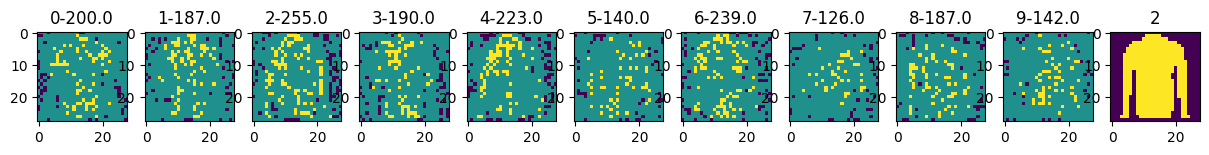

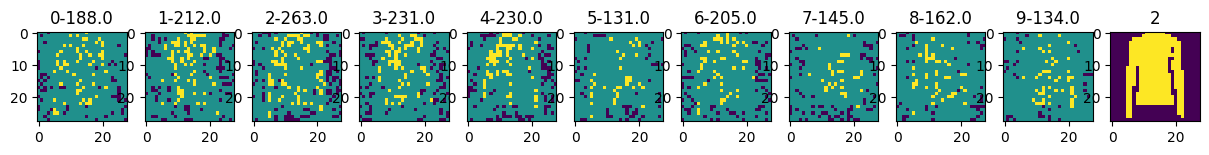

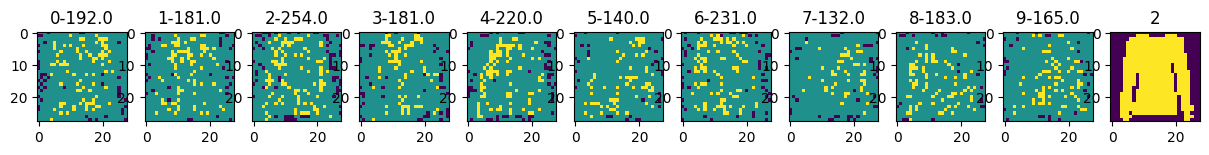

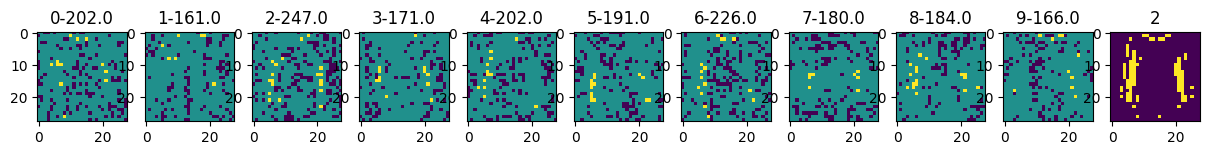

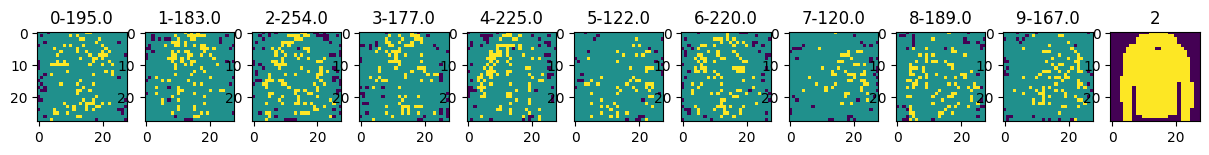

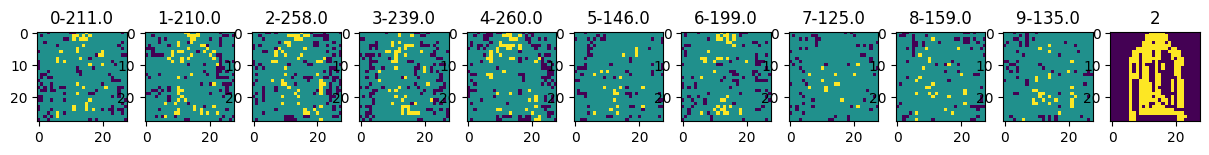

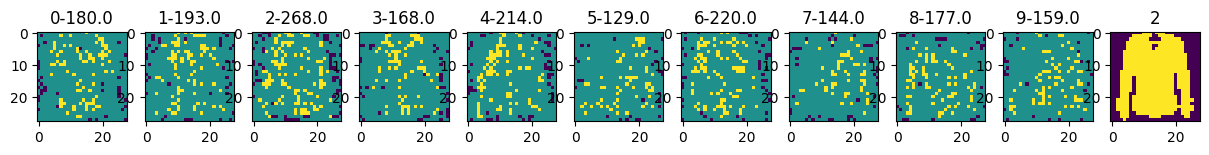

In [173]:
mode = "sf"  # Options: "sp"/"sf"
thresholds = [0.0]
p_type = "FP"
class_num = 2

# Switching Frequency/Probability based local explanations
model.flatten = lambda x: torch.flatten(x).reshape(1, shape[0] * shape[1])

def visualize_class_data(g, data, outputs, ax, mode, thresholds):
    for i, output_node in enumerate(outputs): 
        im = []
        for threshold in thresholds: 
            img, fan_in, pixels = visualize_fan_in(g.g, output_node, threshold, True, False)
            im.append(img)

        img = np.average(im, axis=0)
        overlap = np.array(img.flatten() == (data * 2 - 1).cpu().detach().numpy()).astype(int)
        
        ax[i].imshow((img.flatten() * overlap).reshape((shape[0], shape[1], 1)))
        ax[i].title.set_text(f"{i}-{np.sum(np.abs(img))}")
    
    ax[len(outputs)].imshow(data.reshape((shape[0], shape[1], 1)))
    ax[len(outputs)].title.set_text(f"{np.argmax(np.array(g.forward(data.float()).cpu().detach()))}")
    
    
for k, (data, label) in enumerate(class_specific_datasets[f'{p_type}_class'][class_num].dataset): 
    g = lg.LogicGraph(model)
    
    # Compute either sf or sp based on the mode
    if mode == "sf": 
        g.compute_sf(data.to(float))
    elif mode == "sp":
        g.compute_sp(data.to(float))
    
    fig, ax = plt.subplots(1, len(outputs) + 1, figsize=(15, 10))
    
    # Call the function to handle the visualization logic
    visualize_class_data(g, data, outputs, ax, mode, thresholds)
    
    plt.show()
    
    if k > 5: 
        break


Compare Evidence for TP/FN/FP cases

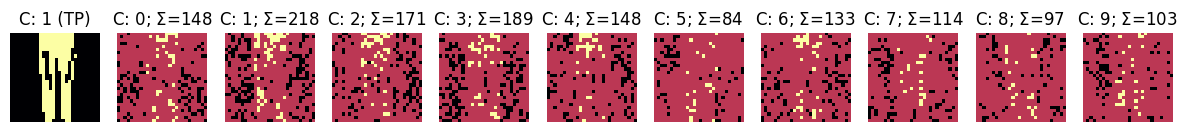

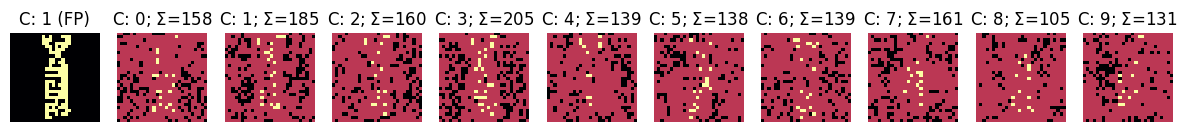

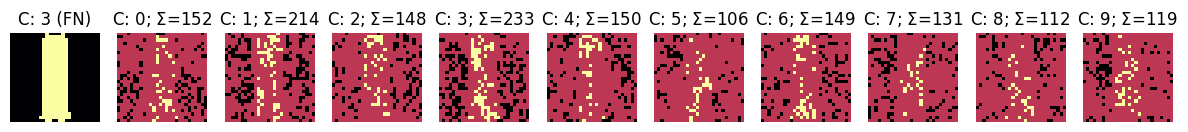

In [174]:
from matplotlib import rc

def visualize_class_data(dataset, class_name, label, model, outputs, shape):
    for k, (data, _) in enumerate(dataset):
        g = lg.LogicGraph(model)
        g.compute_sf(data.float())
        
        fig, ax = plt.subplots(1, len(outputs) + 1, figsize=(15, 10))
        thresholds = [0.0]
        
        for i, output_node in enumerate(outputs):
            im = []
            for threshold in thresholds:
                img, fan_in, pixels = visualize_fan_in(g.g, output_node, threshold, True, False)
                im.append(img)
            
            img = np.average(im, axis=0)
            overlap = np.array(img.flatten() == (data * 2 - 1).cpu().detach().numpy()).astype(int)
            
            ax[i + 1].imshow((img.flatten() * overlap).reshape((shape[0], shape[1], 1)), "inferno", vmin=-1, vmax=1)
            ax[i + 1].title.set_text(f"C: {i}; $\Sigma$={int(np.sum(np.abs(img).flatten() * overlap))}")
            ax[i + 1].set_axis_off()
        
        ax[0].imshow(data.reshape((shape[0], shape[1], 1)), "inferno")
        ax[0].title.set_text(f"C: {np.argmax(np.array(g.forward(data.float()).cpu().detach()))} ({class_name})")
        ax[0].set_axis_off()
        
        plt.show()
        
        break

# Visualize True Positive, False Positive, and False Negative class data
index = 1
visualize_class_data(class_specific_datasets['TP_class'][index].dataset, 'TP', label, model, outputs, shape)
visualize_class_data(class_specific_datasets['FP_class'][index].dataset, 'FP', label, model, outputs, shape)
visualize_class_data(class_specific_datasets['FN_class'][index].dataset, 'FN', label, model, outputs, shape)
